**Due to github's static rendering of files, plots and images are not visible. For a richer view of this notebook follow this URL https://nbviewer.jupyter.org/ and paste the GitHub URL where prompted**

# Exploratory Analysis of Ohio Mortgage Refinancing Data With Machine Learning Models

> **This notebook utilizes four different machine learning models to make predictions about whether or not somebody will be approved for a mortgage refinancing loan. These models use 2017 mortgage data gathered from the United States consumer finance public respiratory. Column interpretations and numerical representations can be found here: https://files.consumerfinance.gov/hmda-historic-data-dictionaries/lar_record_codes.pdf**

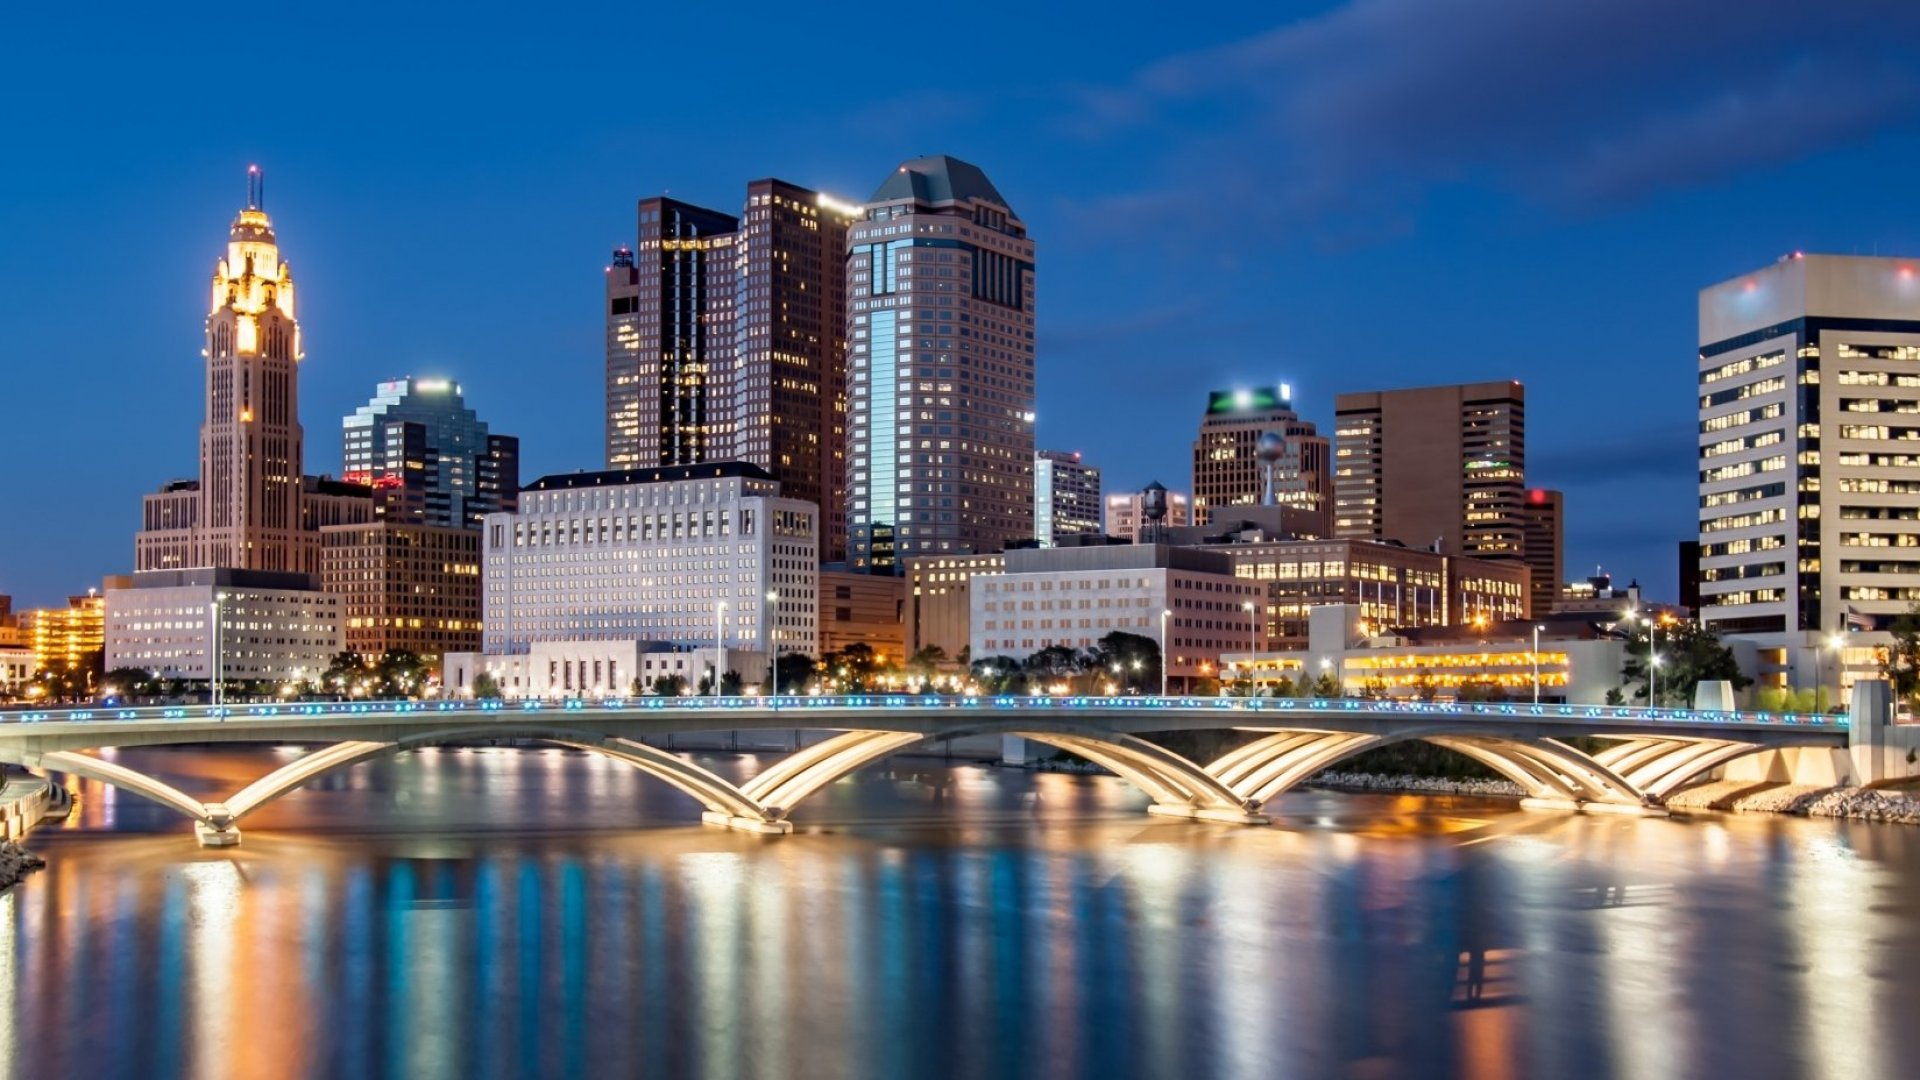

## Import Dependencies 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib.axes
import statsmodels.api as sm
import tensorflow as tf
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from math import sqrt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
%matplotlib inline

from sklearn.svm import SVC,LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc
from scipy.stats import skew
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from keras.models import Sequential
from keras.layers import Dense

## Read In Data 

> These machine learning models are only concerned with predicting whether or not an individual will be approved for a refinancing loan. Therefore, we are eliminating all data that is not relevant to refinancing approval/denial. Additionally, redundant data, non-numerical data, and data that was uniform across all rows have been removed. 

In [2]:
Lower = pd.read_csv('/Users/chriscastaldo/Desktop/Mortgage-Machine-Learning/Data/Processed/Mortgage.csv')

> The cleaned dataframe has 27 variables with 117,110 non-null values. However, the values are not evenly distributed. Some variables have a significant amount of null values (**msmad**).

In [3]:
Lower.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3695509 entries, 0 to 3695508
Data columns (total 30 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   agency_code                     int64  
 1   loan_type                       int64  
 2   property_type                   int64  
 3   owner_occupancy                 int64  
 4   loan_amount_000s                float64
 5   msamd                           float64
 6   state_name                      object 
 7   state_abbr                      object 
 8   state_code                      float64
 9   county_name                     object 
 10  county_code                     float64
 11  census_tract_number             float64
 12  applicant_ethnicity             int64  
 13  co_applicant_ethnicity          int64  
 14  applicant_race_name_1           object 
 15  applicant_race_1                int64  
 16  co_applicant_race_1             int64  
 17  applicant_sex_name         

## Ratio of Approved Loans and Rejected Loans

> In these models we want to predict whether or not somebody will be approved for a refinancing loan. The first step is to plot the ratio of accepted vs rejected loans to get a better understanding of the distribution

1    0.737639
0    0.262361
Name: Loan_Accepted, dtype: float64

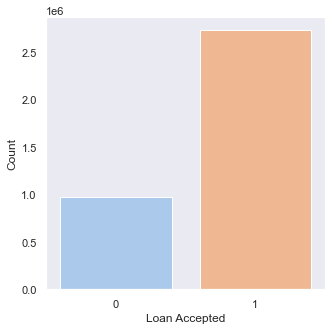

In [4]:
sns.set(style="dark")
plt.figure(figsize=(5,5))
ax = sns.countplot(x="Loan_Accepted", data=Lower, palette = "pastel")
ax.set(xlabel='Loan Accepted', ylabel='Count')
Lower["Loan_Accepted"].value_counts(normalize = 'index')

> As shown above, roughly 71% of loans were approved in 2017 while 29% were denied

## Ratio of Loan Applications by County

> Here we can see the amount of mortgage applications by state. California  outpaced the rest of the country by a pretty wide margin while Vermont and Whyoming had the least applications.

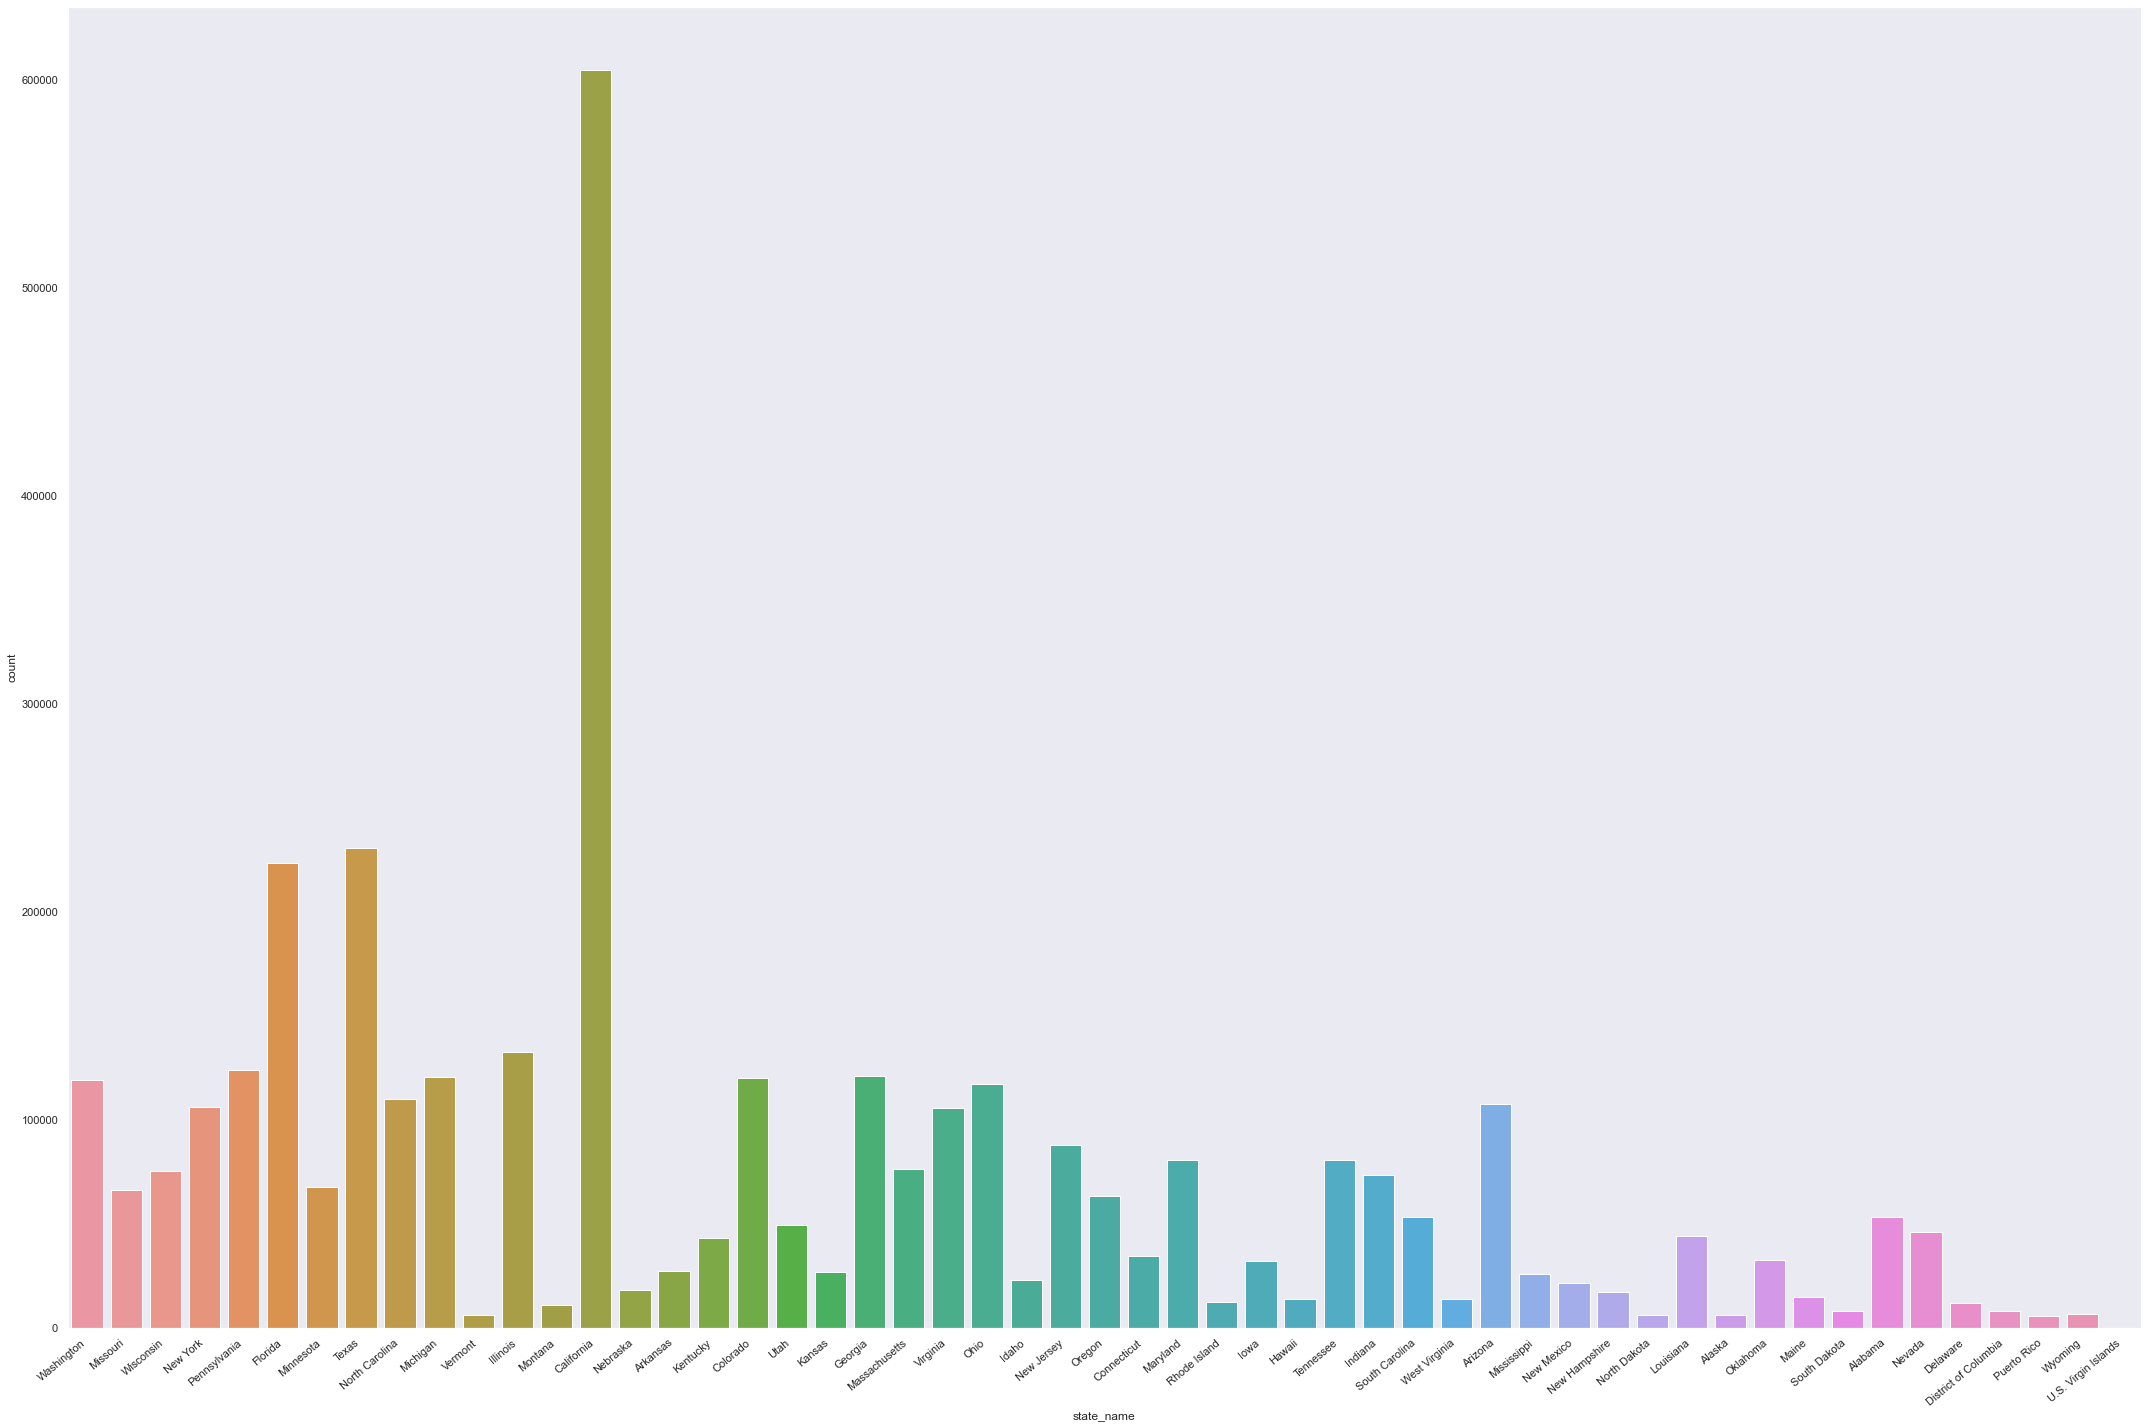

In [6]:
sns.set(style="dark")
plt.figure(figsize=(30,20))
ax = sns.countplot(x="state_name", data=Lower)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

## Demographics

> Unfortunately, this dataset had very little personal information about each applicant. Variables such as **age**, **education**, and **credit history** may have had a significant impact in the models' predictive abilities.

#### Applicant Gender

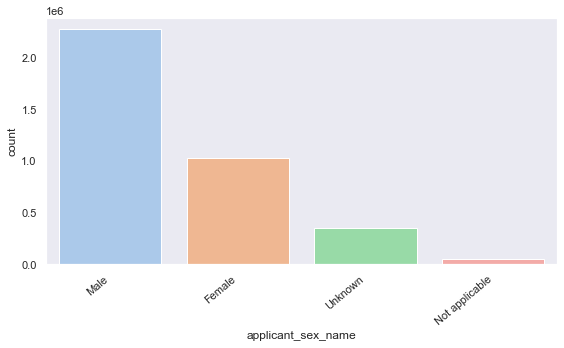

In [7]:
Lower.loc[Lower['applicant_sex_name'].str.contains('Information not')] = 'Unknown'

sns.set(style="dark")
plt.figure(figsize=(8,5))
ax = sns.countplot(x="applicant_sex_name", data=Lower, palette = "pastel")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

#### Applicant Ethnicity

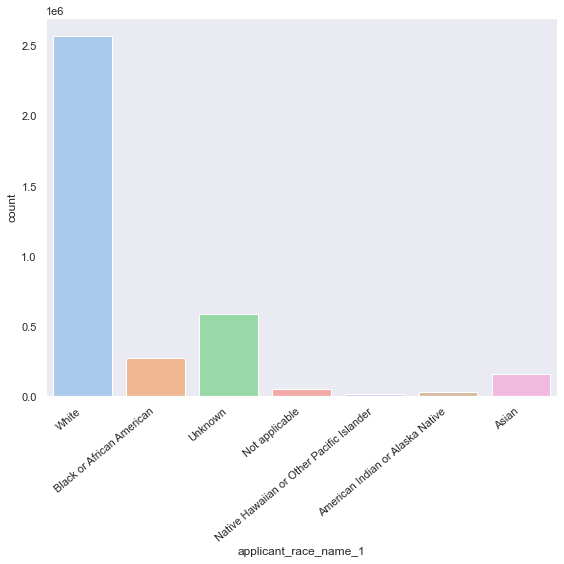

In [8]:
Lower.loc[Lower['applicant_race_name_1'].str.contains('Information not')] = 'Unknown'

sns.set(style="dark")
plt.figure(figsize=(8,8))
ax = sns.countplot(x="applicant_race_name_1", data=Lower, palette = "pastel")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [9]:
Lower = Lower[Lower.loan_type != 'Unknown']

## Income to Loan Request Scatter Plot 

#### 1 = Approved | 0 = Denied

> This is a scatter plot that maps the applicant’s income with their loan request. Yellow dots represent an approved application. Purple dots represent a rejected application. As shown by the graph, most applicants’ income and loan request are less than $100,000

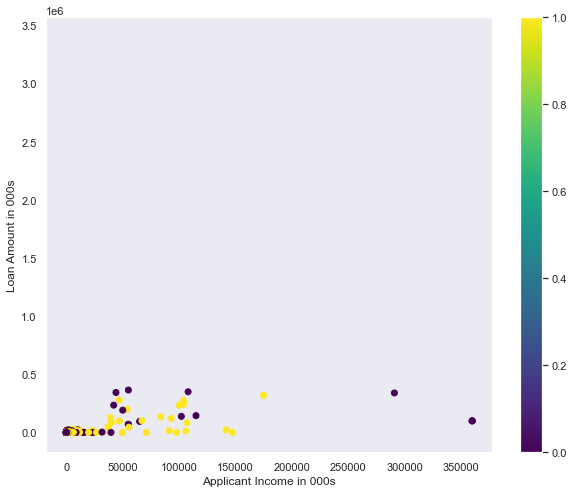

In [10]:
Lower = Lower[Lower.loan_type != 'Unknown']

plt.figure(figsize=(10,8))
plt.scatter(Lower['applicant_income_000s'], Lower['loan_amount_000s'], c = Lower['Loan_Accepted'], cmap=plt.cm.viridis)
plt.xlabel('Applicant Income in 000s')
plt.ylabel('Loan Amount in 000s')
plt.colorbar()
plt.show()

#### Drop remaining non-numerical columns to start fitting data for models 

In [11]:
Lower.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3107026 entries, 0 to 3695508
Data columns (total 30 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   agency_code                     object
 1   loan_type                       object
 2   property_type                   object
 3   owner_occupancy                 object
 4   loan_amount_000s                object
 5   msamd                           object
 6   state_name                      object
 7   state_abbr                      object
 8   state_code                      object
 9   county_name                     object
 10  county_code                     object
 11  census_tract_number             object
 12  applicant_ethnicity             object
 13  co_applicant_ethnicity          object
 14  applicant_race_name_1           object
 15  applicant_race_1                object
 16  co_applicant_race_1             object
 17  applicant_sex_name              object
 18  ap

In [12]:
Lower.drop(Lower.columns[[6, 7, 9, 14, 17]], axis=1, inplace=True)

## Skewness:

> Skewness is a measure of the asymmetry of a variables distribution over its mean. 

In [13]:
Lower.skew()

agency_code                         -1.098906
loan_type                            1.679304
property_type                        7.688005
owner_occupancy                      2.900393
loan_amount_000s                  1053.394961
msamd                               -0.226795
state_code                           0.200806
county_code                          3.753221
census_tract_number                  1.312993
applicant_ethnicity                  1.020025
co_applicant_ethnicity              -0.284157
applicant_race_1                    -1.799542
co_applicant_race_1                 -0.688187
applicant_sex                        1.893364
co_applicant_sex                    -0.312485
applicant_income_000s              154.943710
purchaser_type                       1.634974
lien_status                          6.198281
population                           3.554479
minority_population                  0.924157
hud_median_family_income             0.784516
tract_to_msamd_income             

> We can see above that some metrics are heavily skewed **(applicant_income_000s, loan_amount_000s)**. Heavily skewed data will impair the models’ assumptions and its ability to properly evaluate feature importance

> Additionally, some metrics are mildly skewed **(property_type, lien_status, property_type)** however these are categorical so we will not worry about them. 

> To remedy this issue, we will take the logarithmic value of **applicant_income_000s** and **loan_amount_000s** 

In [14]:
import math
to_log = ["loan_amount_000s", "applicant_income_000s"]
Lower[to_log] = Lower[to_log].applymap(math.log)
Lower.skew()

agency_code                      -1.098906
loan_type                         1.679304
property_type                     7.688005
owner_occupancy                   2.900393
loan_amount_000s                 -0.045774
msamd                            -0.226795
state_code                        0.200806
county_code                       3.753221
census_tract_number               1.312993
applicant_ethnicity               1.020025
co_applicant_ethnicity           -0.284157
applicant_race_1                 -1.799542
co_applicant_race_1              -0.688187
applicant_sex                     1.893364
co_applicant_sex                 -0.312485
applicant_income_000s             0.259914
purchaser_type                    1.634974
lien_status                       6.198281
population                        3.554479
minority_population               0.924157
hud_median_family_income          0.784516
tract_to_msamd_income             1.287042
number_of_owner_occupied_units    3.908385
number_of_1

## Distribution of Income and Loan Amount after Skew Normalization

> We can see here that the skews of **applicant_income_000** and **loan_amount_000** have been normalized and now gravitate at the center.

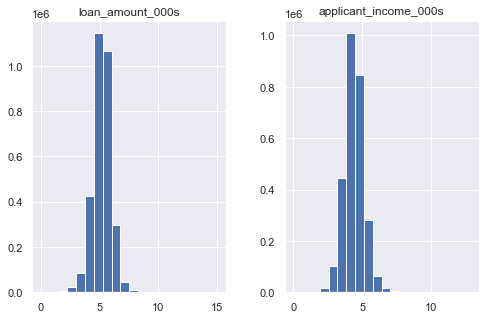

In [15]:
Lower.hist(figsize=(8,5), bins=20)
plt.show()

## Kernel Density Estimates

> Kernel density estimation is a way to estimate the probability of a variable at a certain instance. The plots below show the density of loan acceptance based on all of the numerical features in the dataset. This gives a visual representation of what factors affect loan acceptance the most. 

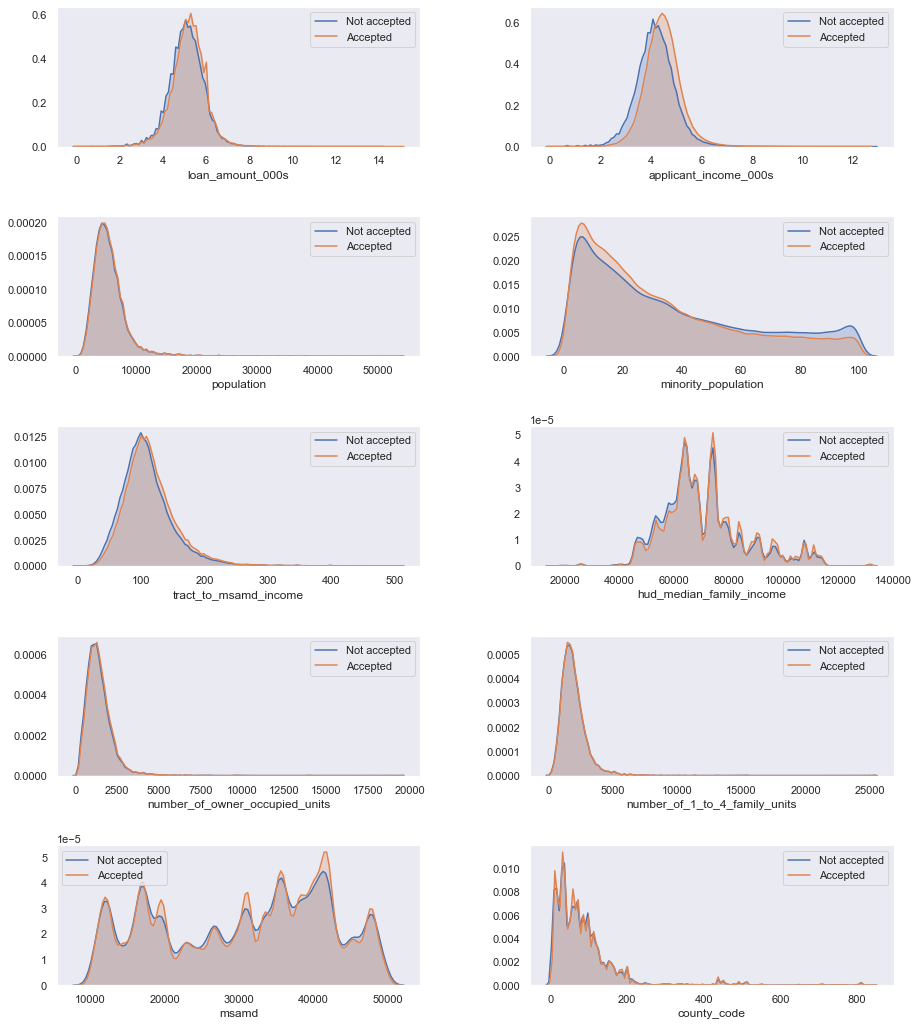

In [16]:
Cols = ["loan_amount_000s", "applicant_income_000s", "population", "minority_population", "tract_to_msamd_income", 
        "hud_median_family_income","number_of_owner_occupied_units", "number_of_1_to_4_family_units", "msamd", 
        "county_code"]

fig, axes = plt.subplots(ncols = 2, nrows = 5, figsize = (15,18))
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)

for ax, col in zip(axes.flatten(), Cols) :
    sns.kdeplot(Lower[Lower["Loan_Accepted"] == 0][col], shade="True", label="Not accepted", ax = ax)
    sns.kdeplot(Lower[Lower["Loan_Accepted"] == 1][col], shade="True", label="Accepted", ax = ax)
    ax.set_xlabel(col)

## Correlation Matrix

In [17]:
Lower = Lower.astype('float64')

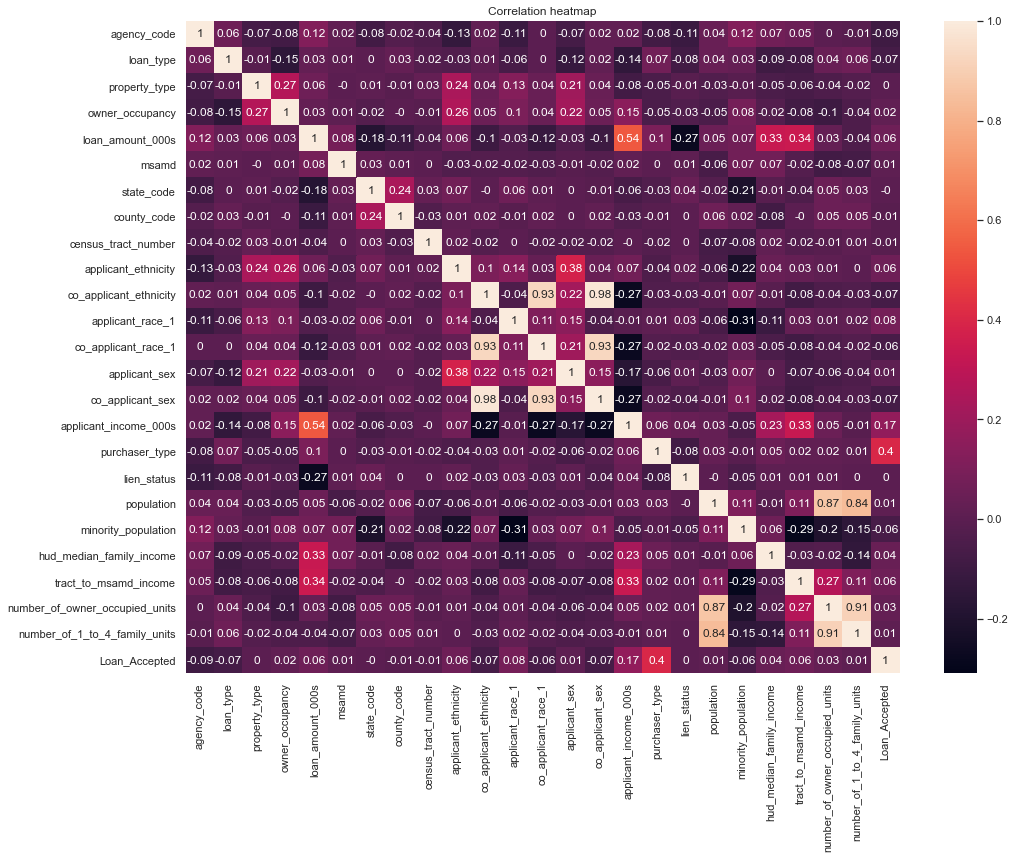

In [18]:
plt.figure(figsize=(16,12))
sns.heatmap(Lower.corr().round(decimals=2), annot=True)
plt.title("Correlation heatmap")
plt.show()

# Machine Learning

### Feature Selection

> For our models we will limit our features by only selecting those that have more than a 5% correlation with our desired outcome. We will also drop all null values from the dataframe.

In [19]:
correlations = Lower.corr(method='pearson')
correlations_price = abs(correlations['Loan_Accepted'])
print(correlations_price[correlations_price > 0.05]
      .sort_values(ascending=False).to_string())

Loan_Accepted             1.000000
purchaser_type            0.397750
applicant_income_000s     0.171767
agency_code               0.090388
applicant_race_1          0.083652
co_applicant_ethnicity    0.071175
co_applicant_sex          0.071038
loan_type                 0.066458
tract_to_msamd_income     0.063612
minority_population       0.059771
loan_amount_000s          0.059494
co_applicant_race_1       0.059161
applicant_ethnicity       0.057329


In [20]:
Lower.head()

,agency_code,loan_type,property_type,owner_occupancy,loan_amount_000s,msamd,state_code,county_code,census_tract_number,applicant_ethnicity,...,applicant_income_000s,purchaser_type,lien_status,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,Loan_Accepted
0,9.0,1.0,1.0,1.0,5.123964,44060.0,53.0,63.0,127.01,2.0,...,4.094345,0.0,1.0,3733.0,4.580000,63900.0,86.239998,861.0,1241.0,0.0
1,7.0,1.0,1.0,2.0,4.477337,44180.0,29.0,77.0,11.00,2.0,...,3.970292,3.0,1.0,3566.0,11.830000,55200.0,74.290001,573.0,1261.0,1.0
2,2.0,1.0,1.0,2.0,4.543295,29404.0,55.0,59.0,22.00,2.0,...,3.433987,0.0,1.0,3779.0,15.370000,91600.0,71.129997,1019.0,1465.0,1.0
3,7.0,2.0,1.0,1.0,4.553877,41180.0,29.0,189.0,2108.04,2.0,...,3.258097,0.0,1.0,9786.0,87.360001,74300.0,100.750000,2517.0,3325.0,0.0
5,7.0,3.0,1.0,1.0,4.672829,42540.0,42.0,79.0,2173.00,2.0,...,2.484907,0.0,1.0,3382.0,20.280001,59500.0,93.230003,1016.0,1389.0,0.0


> 15 columns meet the correlative threshold. The other 9 will be dropped from the dataset.

In [21]:
Lower.drop(Lower.columns[[6, 7, 9, 14, 17, 2, 3, 5, 6, 7, 8, 12, 16, 17, 22, 23]], axis=1, inplace=True)

In [22]:
Lower = Lower.dropna()

# Model Evaluation Function

> This function will plot the results of the **Random Forest, Logistical Regression**, and **Gaussian Naive Bayes** models. In addition to the results it also will plot the confusion matrix, the ROC curve, and the precision recall curve.

In [23]:
def mod_eval(df , predictions, predprob, y_test, title):
  
    cm = confusion_matrix(df.Loan_Accepted[y_test.index], predictions)
    sns.heatmap(cm, annot = True, fmt = '.7g', xticklabels = ['No', 'Yes'], yticklabels = ['No', 'Yes']).set_title(title)
    plt.xlabel('Real Values') 
    plt.ylabel('Predicted Values')
    print(classification_report(df.Loan_Accepted[y_test.index], predictions))
    
    f, axes = plt.subplots(1,2,figsize= (20,6),squeeze=False)
    
    false_positives, true_positives, _ = roc_curve(df.Loan_Accepted[y_test.index], predprob[:,1])
    roc_auc = auc(false_positives, true_positives)
    
    axes[0,0].plot(false_positives, true_positives, lw = 3)
    axes[0,0].set_title('{} ROC curve (area = {:0.2f})'.format(title, roc_auc))
    axes[0,0].set(xlabel='False Positive %',ylabel='True Positive %')
    axes[0,0].grid(b=True, which='both', axis='both', color='grey', linestyle = '-', linewidth = '0.5')

    precision, recall, thresholds = precision_recall_curve(y_test, predprob[:,1])
    best_index = np.argmin(np.abs(precision-recall))
    
    axes[0,1].plot(precision,recall)
    axes[0,1].set_title('{} Precision-Recall Curve'.format(title))
    axes[0,1].set(xlabel='Precision', ylabel='Recall', xlim=(0.4,1.05))
    axes[0,1].plot(precision[best_index],recall[best_index],'o',color='r')
    axes[0,1].grid(b=True, which='both', axis='both', color='grey', linestyle = '-', linewidth = '0.5')

# Dataset Function

> This function creates and fits the training and testing dataset for the **Random Forest, Logistical Regression**, and **Gaussian Naive Bayes** models.

In [24]:
def model_training(classifier,df):
    clf = classifier
    t = df.drop(columns=['Loan_Accepted'])
    X_train, X_test, y_train, y_tests = train_test_split(t, df['Loan_Accepted'], test_size = .33, stratify = df['Loan_Accepted'])
    clf.fit(X_train, y_train)
    return clf

# Random Forest

### Results of the Random Forest Model

> **Precision**: The model was correct 78% of the time in predicting whether somebody would be rejected for a loan. The model was correct 77% of the time in predicting whether somebody would be approved for a loan. 

> **Recall**: The model was only able to identify 16% of loan rejections in the dataset. The model was  able to ideneify 98% of approved loans in the dataset


> **True Negatives**: 59700

> **True Positives**: 1013801

> **False Negatives**: 16900

> **False Positives**: 304003

              precision    recall  f1-score   support

         0.0       0.78      0.16      0.27    363703
         1.0       0.77      0.98      0.86   1030701

    accuracy                           0.77   1394404
   macro avg       0.77      0.57      0.57   1394404
weighted avg       0.77      0.77      0.71   1394404



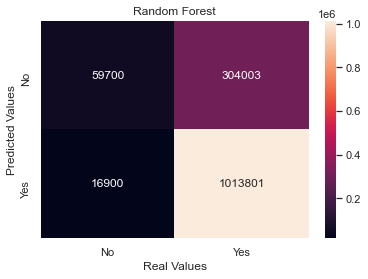

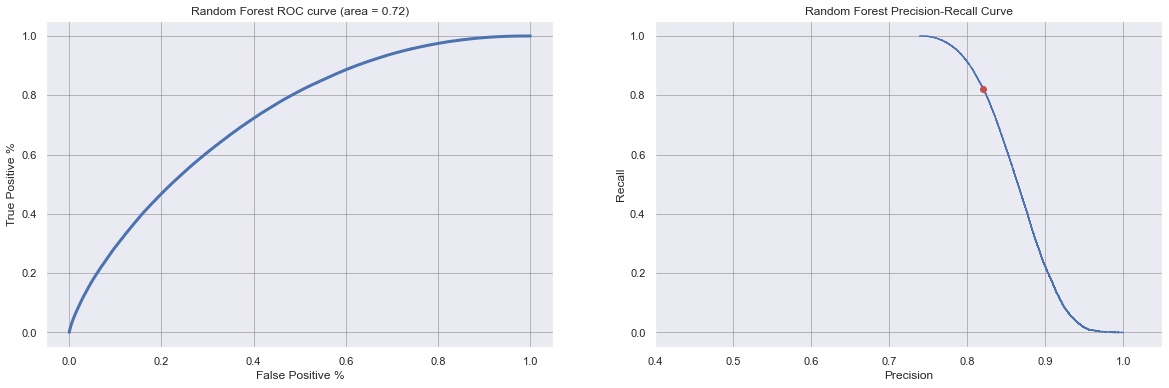

In [25]:
random_forest = model_training(RandomForestClassifier(random_state = 42, n_jobs = 4, n_estimators = 100, 
                                                      max_depth = 16), Lower)

t = Lower.drop(columns=['Loan_Accepted'])
X_train, X_test, y_train, y_test = train_test_split(t, Lower['Loan_Accepted'], test_size = .5, 
                                                    stratify = Lower['Loan_Accepted'])

mod_eval(Lower, random_forest.predict(X_test), random_forest.predict_proba(X_test), y_test, 'Random Forest')
plt.show()

> The area underneath the **ROC** is equal to 72% of the total area, meaning this model is fairly accurate. This is a measure only of the model’s ability to classify true positives and true negatives. It doesn't measure false negatives or false positives.

> The **Precision-Recall** curve measures the trade-off of between Precision and Recall. As shown by the chart, a model with ~99% accuracy on labeling true positives and true negatives will miss 99% of the data. A model that doesn't miss any of the data will mislabel true positives and true negatives ~25% of the time. The ideal trade-off is indicated by the red dot and exists at ~83% Precision with ~83% Recall. 

# Logistical Regression

### Results of the Logistic Regression Model

> **Precision**: The model was correct 59% of the time in predicting whether somebody would be rejected for a loan. The model was correct 75% of the time in predicting whether somebody would be approved for a loan. 

> **Recall**: The model was only able to identify 0.05% of loan rejections in the dataset. The model was  able to ideneify 99% of approved loans in the dataset


> **True Negatives**: 18271

> **True Positives**: 1018168

> **False Negatives**: 12533

> **False Positives**: 345432

              precision    recall  f1-score   support

         0.0       0.59      0.05      0.09    363703
         1.0       0.75      0.99      0.85   1030701

    accuracy                           0.74   1394404
   macro avg       0.67      0.52      0.47   1394404
weighted avg       0.71      0.74      0.65   1394404



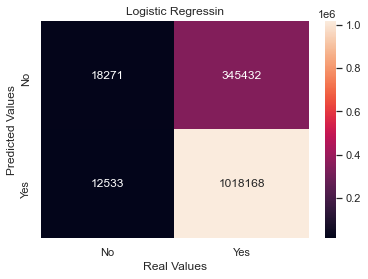

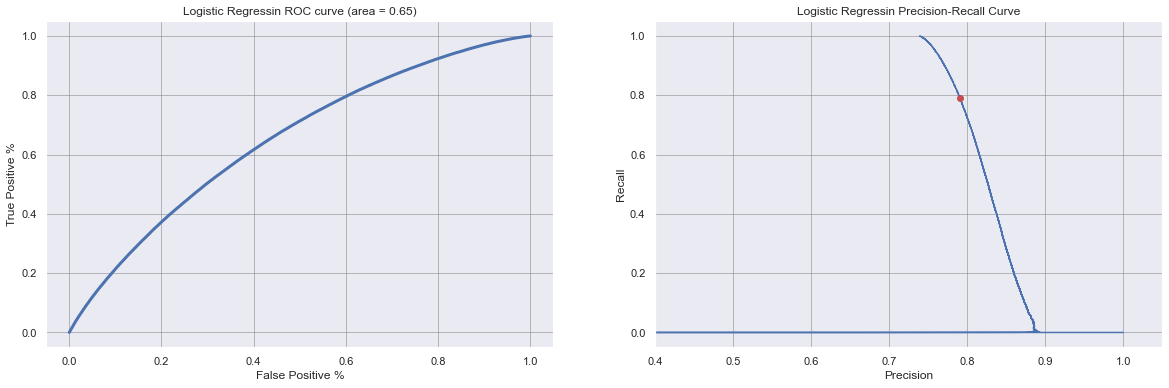

In [26]:
lr = model_training(LogisticRegression(C =.01,  penalty = 'l1', solver='liblinear', max_iter=1000) , Lower)

t=Lower.drop(columns=['Loan_Accepted'])
X_train, X_test, y_train, y_test = train_test_split(t, Lower['Loan_Accepted'], test_size=0.5, random_state = 42, 
                                                    stratify=Lower['Loan_Accepted'])

t = .5
predprob = lr.predict_proba(X_test)

pred_y = [np.ceil(x) if x >= t else np.floor(x) for x in predprob[:,1]]

mod_eval(Lower, pred_y, lr.predict_proba(X_test), y_test, 'Logistic Regressin') 
plt.show()

> The area underneath the **ROC** is equal to 65% of the total area, meaning this model is fairly accurate. This is a measure only of the model’s ability to classify true positives and true negatives. It doesn't measure false negatives or false positives.

> The **Precision-Recall** curve measures the trade-off of between Precision and Recall. As shown by the chart, a model with ~99% accuracy on labeling true positives and true negatives will miss 100% of the data. A model that doesn't miss any of the data will mislabel true positives and true negatives ~25% of the time. The ideal trade-off is indicated by the red dot and exists at ~79% Precision with ~80% Recall. 

# Gaussian Naive Bayes

### Results of the Gaussian Naive Bayes Model

> **Precision**: The model was correct 46% of the time in predicting whether somebody would be rejected for a loan. The model was correct 76% of the time in predicting whether somebody would be approved for a loan. 

> **Recall**: The model was only able to identify 0.17% of loan rejections in the dataset. The model was  able to ideneify 93% of approved loans in the dataset


> **True Negatives**: 60541

> **True Positives**: 958925

> **False Negatives**: 71776

> **False Positives**: 303162

              precision    recall  f1-score   support

         0.0       0.46      0.17      0.24    363703
         1.0       0.76      0.93      0.84   1030701

    accuracy                           0.73   1394404
   macro avg       0.61      0.55      0.54   1394404
weighted avg       0.68      0.73      0.68   1394404



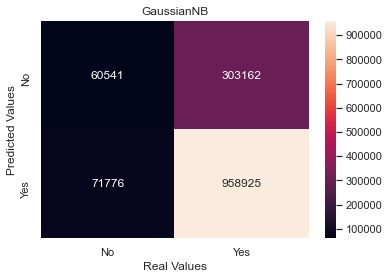

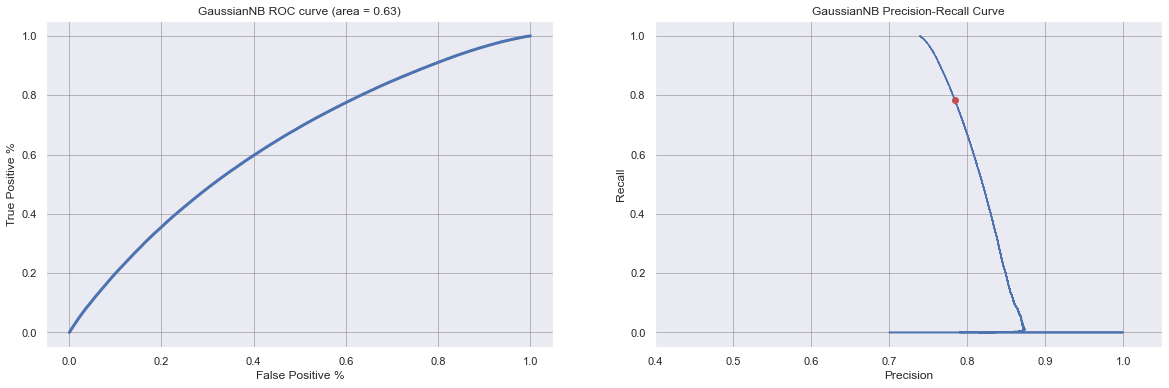

In [27]:
gnb = model_training(GaussianNB(), Lower)

t = Lower.drop(columns=['Loan_Accepted'])
X_train, X_test, y_train, y_test = train_test_split(t , Lower['Loan_Accepted'], test_size=.5, random_state = 42, 
                                                    stratify = Lower['Loan_Accepted'])


t = .5
predprob = gnb.predict_proba(X_test)

pred_y = [np.ceil(x) if x >= t else np.floor(x) for x in predprob[:,1]]
mod_eval(Lower,pred_y, gnb.predict_proba(X_test), y_test, 'GaussianNB')
plt.show()

> The area underneath the **ROC** is equal to 63% of the total area, meaning this model is fairly accurate. This is a measure only of the model’s ability to classify true positives and true negatives. It doesn't measure false negatives or false positives.

> The **Precision-Recall** curve measures the trade-off of between Precision and Recall. As shown by the chart, a model with ~99% accuracy on labeling true positives and true negatives will miss 100% of the data. A model that doesn't miss any of the data will mislabel true positives and true negatives ~25% of the time. The ideal trade-off is indicated by the red dot and exists at ~78% Precision with ~78% Recall. 

# Neural Network

### Data Preperation for Neural Network

In [43]:
Lower_NN = Lower.values

In [46]:
X = Lower_NN[:,0:11]
Y = Lower_NN[:,11]

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(1952164, 11) (418321, 11) (418322, 11) (1952164,) (418321,) (418322,)


### Neural Network

In [51]:
model = Sequential([

    Dense(100, activation='relu', input_shape=(11,)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid'),
])

In [52]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
hist = model.fit(X_train, Y_train, batch_size = 264, epochs = 35, validation_data=(X_val, Y_val))

Epoch 1/35
7395/7395 [==============================] - 13s 2ms/step - loss: 0.5424 - accuracy: 0.7450 - val_loss: 0.5422 - val_accuracy: 0.7456
Epoch 2/35
7395/7395 [==============================] - 14s 2ms/step - loss: 0.5352 - accuracy: 0.7491 - val_loss: 0.5326 - val_accuracy: 0.7511
Epoch 3/35
7395/7395 [==============================] - 14s 2ms/step - loss: 0.5334 - accuracy: 0.7506 - val_loss: 0.5323 - val_accuracy: 0.7514
Epoch 4/35
7395/7395 [==============================] - 13s 2ms/step - loss: 0.5325 - accuracy: 0.7513 - val_loss: 0.5313 - val_accuracy: 0.7522
Epoch 5/35
7395/7395 [==============================] - 13s 2ms/step - loss: 0.5319 - accuracy: 0.7517 - val_loss: 0.5312 - val_accuracy: 0.7529
Epoch 6/35
7395/7395 [==============================] - 13s 2ms/step - loss: 0.5312 - accuracy: 0.7522 - val_loss: 0.5304 - val_accuracy: 0.7524
Epoch 7/35
7395/7395 [==============================] - 13s 2ms/step - loss: 0.5308 - accuracy: 0.7524 - val_loss: 0.5301 - val_ac

## Neural Network Evaluation

In [54]:
model.evaluate(X_test, Y_test)[1]

13073/13073 [==============================] - 10s 795us/step - loss: 0.5301 - accuracy: 0.7523


0.7522530555725098

> This Neural Network was able to predict who would be approved for a refinancing loan with **75% accuracy** 

## Plots

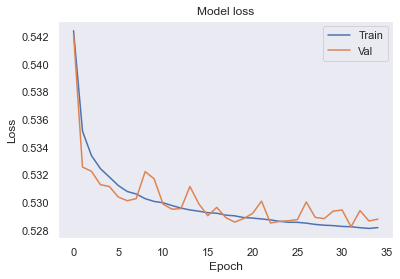

In [55]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

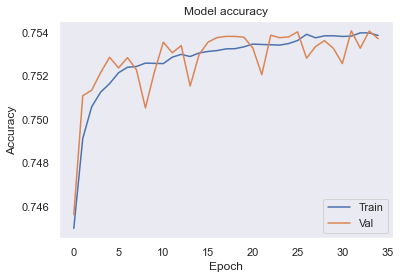

In [56]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

> **Above we can see that the Validation data is more erratic than the Training data and does not completely match the line. This is an indication that the model is slightly over-fitting.**

# Model Analysis 

> If the goal of the company is to identify clients who are the most qualified to receive a refinancing loan, then we want a model that maximizes true positives and minimizes false positives meaning precision is more important than recall. With this considered, the models that perform best for the given task are ranked as follows:

> **1:** Neural Network

> **2:** Random Forest 

> **3:** Logistic Regression

> **4:** Gaussian Naive Bayes